In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

In [2]:
import os
import sys
import string
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

from scipy.stats import ttest_ind
from scipy.spatial.distance import cdist

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D, Input, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.get_logger().setLevel('ERROR')

import transformers
from transformers import BertTokenizer, BertModel, TFBertForSequenceClassification

import torch

import sklearn
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import xgboost
from xgboost import XGBClassifier

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/WordsofWar')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


Mounted at /content/drive


In [4]:
# Print versions
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("nltk:", nltk.__version__)
print("torch:", torch.__version__)
print("sklearn:", sklearn.__version__)
print("tensorflow:", tf.__version__)
print("transformers:", transformers.__version__)
print("xgboost:", xgboost.__version__)

numpy: 1.24.3
pandas: 1.5.3
nltk: 3.8.1
torch: 2.2.1+cu121
sklearn: 1.2.2
tensorflow: 2.13.1
transformers: 4.38.2
xgboost: 2.0.3


### Train/test split

In [17]:
# Read train, validation, and test sets from CSV files
X_train_df = pd.read_csv('X_train.csv')
X_val_df = pd.read_csv('X_val.csv')
X_test_df = pd.read_csv('X_test.csv')
y_train_df = pd.read_csv('y_train.csv')
y_val_df = pd.read_csv('y_val.csv')
y_test_df = pd.read_csv('y_test.csv')

# Convert DataFrames to numpy arrays
X_train = X_train_df.values
X_val = X_val_df.values
X_test = X_test_df.values
y_train = y_train_df['War'].values
y_val = y_val_df['War'].values
y_test = y_test_df['War'].values

In [18]:
# Determine the input shape
input_shape = (X_train.shape[1:])

---

# MLP

In [19]:
# Define the neural network model
model = Sequential([
    Input(shape=input_shape),
    Dense(128,
          activation='relu',
          input_shape=(768,),
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [20]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99, nesterov=True)

# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
30/30 [==============================] - 1s 8ms/step - loss: 4.5321 - accuracy: 0.5683 - val_loss: 4.4389 - val_accuracy: 0.6218
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 4.3804 - accuracy: 0.6166 - val_loss: 4.2601 - val_accuracy: 0.6639
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 4.1653 - accuracy: 0.6334 - val_loss: 4.0262 - val_accuracy: 0.6555
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 3.8896 - accuracy: 0.6786 - val_loss: 3.7405 - val_accuracy: 0.6555
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 3.5953 - accuracy: 0.6975 - val_loss: 3.4511 - val_accuracy: 0.6891
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 3.2902 - accuracy: 0.7195 - val_loss: 3.1575 - val_accuracy: 0.6807
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 2.9853 - accuracy: 0.7426 - val_loss: 2.8616 - val_accuracy: 0.7227
Epoch 8/10
30/30 [==

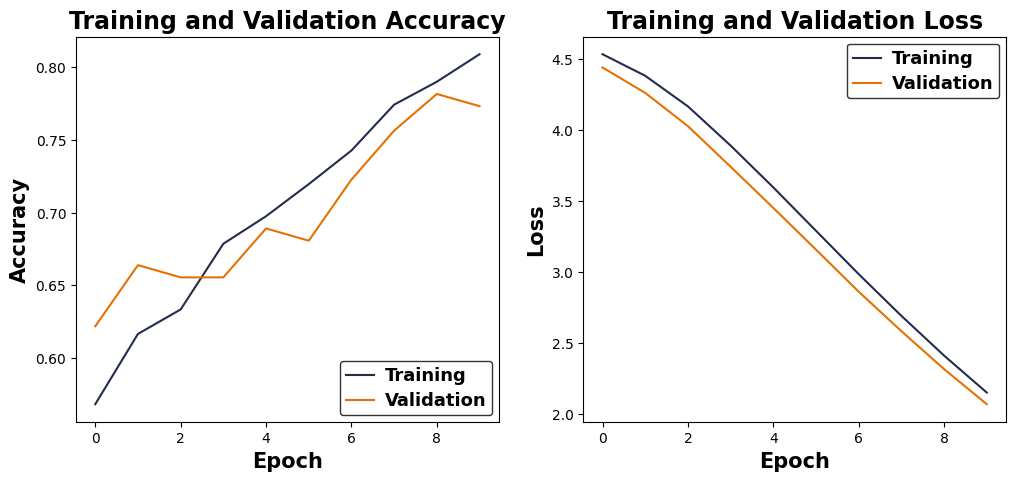

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Accuracy', weight='bold', size=15)
plt.plot(epochs_range, val_acc, label='Validation', color='#E57200')
legend = plt.legend(loc='lower right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Accuracy', weight='bold', size=17)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Loss', weight='bold', size=15)
plt.plot(epochs_range, val_loss, label='Validation', color='#E57200')
legend = plt.legend(loc='upper right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Loss', weight='bold', size=17)

plt.show()

In [23]:
# Predict probs for positive class
y_pred_prob = model.predict(X_test)

# AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Convert probs to class labels
y_pred_class = (y_pred_prob > 0.5).astype(int)

# F1-score
f1 = f1_score(y_test, y_pred_class)

print("AUC-ROC Score:", auc_roc)
print("F1-Score:", f1)

4/4 [==============================] - 0s 2ms/step
AUC-ROC Score: 0.8519886363636363
F1-Score: 0.7747747747747747


---

# Gated RNN (LSTM)

In [24]:
# Reshape input_shape to add a timestep dimension
input_shape_with_timesteps = (1, input_shape[0])

# Define the neural network model
model2 = Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Reshape(input_shape_with_timesteps),
    LSTM(128,
         activation='tanh',
         kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal',
         dropout=0.1,
         recurrent_dropout=0.1),
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
# Train the model
history2 = model2.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
30/30 [==============================] - 3s 16ms/step - loss: 1.7516 - accuracy: 0.6050 - val_loss: 1.5432 - val_accuracy: 0.6134
Epoch 2/10
30/30 [==============================] - 0s 6ms/step - loss: 1.3529 - accuracy: 0.6807 - val_loss: 1.2038 - val_accuracy: 0.6639
Epoch 3/10
30/30 [==============================] - 0s 5ms/step - loss: 1.0413 - accuracy: 0.7532 - val_loss: 0.9780 - val_accuracy: 0.6891
Epoch 4/10
30/30 [==============================] - 0s 5ms/step - loss: 0.8202 - accuracy: 0.8004 - val_loss: 0.7468 - val_accuracy: 0.8067
Epoch 5/10
30/30 [==============================] - 0s 5ms/step - loss: 0.6533 - accuracy: 0.8445 - val_loss: 0.5996 - val_accuracy: 0.8403
Epoch 6/10
30/30 [==============================] - 0s 6ms/step - loss: 0.5268 - accuracy: 0.8697 - val_loss: 0.4947 - val_accuracy: 0.8908
Epoch 7/10
30/30 [==============================] - 0s 6ms/step - loss: 0.4359 - accuracy: 0.8971 - val_loss: 0.4580 - val_accuracy: 0.8739
Epoch 8/10
30/30 [=

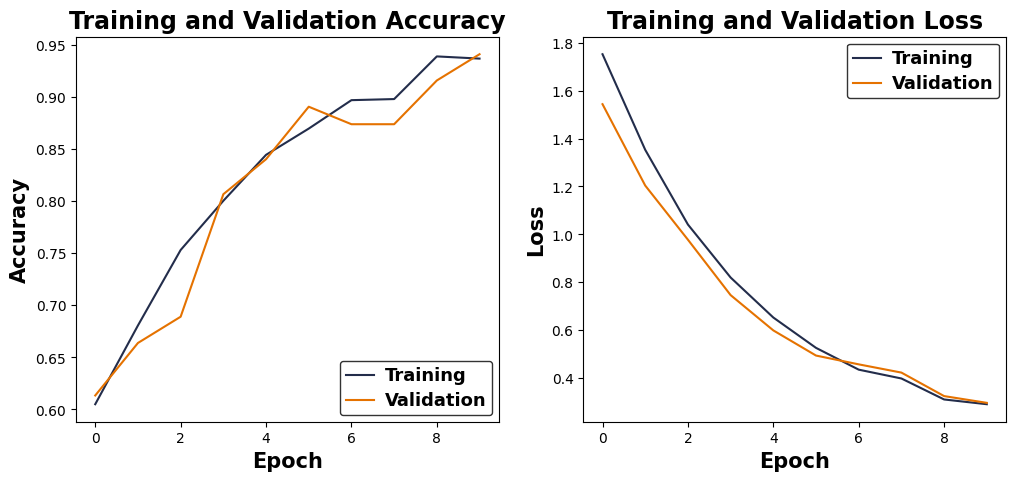

In [27]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Accuracy', weight='bold', size=15)
plt.plot(epochs_range, val_acc2, label='Validation', color='#E57200')
legend = plt.legend(loc='lower right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Accuracy', weight='bold', size=17)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Loss', weight='bold', size=15)
plt.plot(epochs_range, val_loss2, label='Validation', color='#E57200')
legend = plt.legend(loc='upper right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Loss', weight='bold', size=17)

plt.show()

In [28]:
# Predict probs for positive class
y_pred_prob2 = model2.predict(X_test)

# AUC-ROC score
auc_roc2 = roc_auc_score(y_test, y_pred_prob2)

# Convert probs to class labels
y_pred_class2 = (y_pred_prob2 > 0.5).astype(int)

# F1-score
f12 = f1_score(y_test, y_pred_class2)

print("AUC-ROC Score:", auc_roc2)
print("F1-Score:", f12)

4/4 [==============================] - 0s 3ms/step
AUC-ROC Score: 0.9417613636363636
F1-Score: 0.9075630252100839


---

# Transformer

In [29]:
# Convert data into TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and batch the datasets
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(buffer_size=len(X_train), seed=28)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.batch(batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [31]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [32]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# Define the optimizer
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
# Fit the model
print(f'Training model with {tfhub_handle_encoder}')
history3 = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/2


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_2" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 768) dtype=float32>]


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

7/7 [==============================] - 15s 2s/step - loss: 0.2892 - binary_accuracy: 0.9119
Loss: 0.28924286365509033
Accuracy: 0.9119170904159546


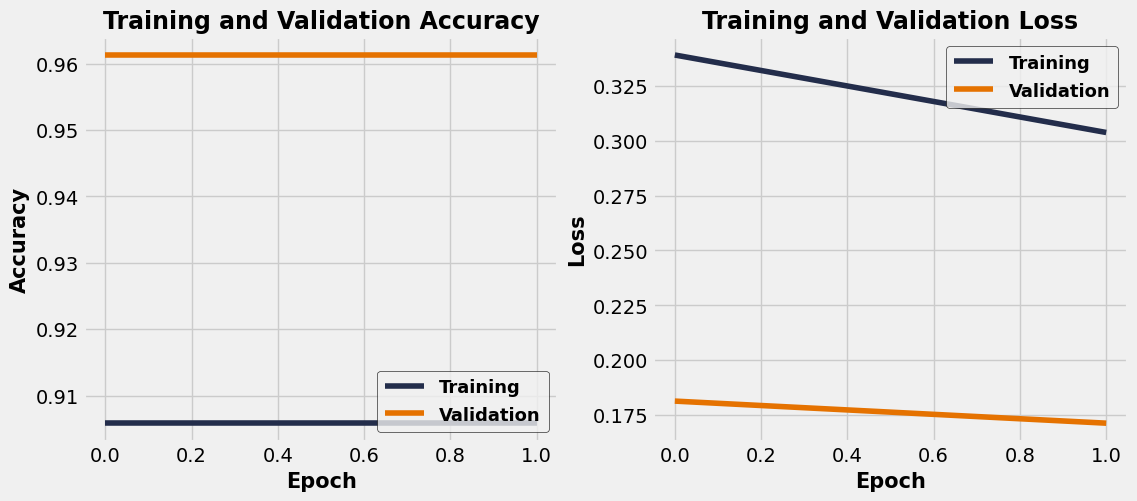

In [ ]:
acc3 = history3.history['binary_accuracy']
val_acc3 = history3.history['val_binary_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Accuracy', weight='bold', size=15)
plt.plot(epochs_range, val_acc3, label='Validation', color='#E57200')
legend = plt.legend(loc='lower right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Accuracy', weight='bold', size=17)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Loss', weight='bold', size=15)
plt.plot(epochs_range, val_loss3, label='Validation', color='#E57200')
legend = plt.legend(loc='upper right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Loss', weight='bold', size=17)

plt.show()

In [ ]:
# Predict probabilities for positive class
y_pred_prob3 = classifier_model.predict(test_ds.map(lambda x, y: x))

# Assuming test_ds yields tuples of (text, label), you need to extract labels for evaluation
y_true = np.concatenate([y for x, y in test_ds])

# AUC-ROC score
auc_roc3 = roc_auc_score(y_true, y_pred_prob3)

# Convert probabilities to class labels
y_pred_class3 = (y_pred_prob3 > 0.5).astype(int)

# F1-score
f13 = f1_score(y_true, y_pred_class3)

print("AUC-ROC Score:", auc_roc3)
print("F1-Score:", f13)

7/7 [==============================] - 16s 2s/step
AUC-ROC Score: 0.6534090909090908
F1-Score: 0.0


---

# Comments on model results:

These results possibly indicate that there are discernible patterns in the text of US presidential speeches that correlate with the US entering a major war  within one year of the speech. This (I think) suggests that Presidents leverage certain language or rhetorical cues in their speeches to prepare the nation for war.

---

# Next Steps:

Professor mentioned that it would be interesting if we can try to identify discriminative features between the two classes (i.e., Interpretable Learning). So, see if we could answer questions like: What is the model seeing in the speech that makes it classify it as leading up to war or what is missing in the other class that makes it classify that way?

To tackle this we might consider:

### __1__: Layer-wise Relevance Propagation (LRP):

Implement LRP to understand the relevance of input features to the model's predictions. This can help us identify which words or phrases in the speeches contribute most significantly to the classification decision.

### __2__: SHAP (SHapley Additive exPlanations):

Use SHAP values to compute the importance of each feature in the context of individual predictions. This technique will provide insights into how each feature influences the model's output.

### __3__: Feature Importance Scores:

After training your model, extract the weights of the first layer (Dense(128)) and analyze which input features have the highest weights. This can give us an idea of which words or phrases are most influential in determining the classification.

### __4__: Attention Mechanisms:

If applicable, incorporate attention mechanisms into your model architecture. Attention mechanisms can highlight which parts of the input sequence are most relevant for making predictions, providing interpretability at the token level.

### __5__: Word Embedding Visualization:

Visualize word embeddings to understand how words are represented in the model's embedding space. This can help us identify clusters of words associated with specific classes (e.g., words related to war).

### __6__: Grad-CAM (Gradient-weighted Class Activation Mapping):

If we use a model architecture with convolutional layers, we might consider apply Grad-CAM to visualize which parts of the input text are most important for the model's predictions. This technique highlights regions of the input that contribute most to the final decision.

---

Since we use an LSTM model, attention mechanisms can be particularly useful in understanding which parts of the input sequences are most relevant for classification.

Here's how we can implement attention mechanisms with our LSTM model:

Define an Attention Layer: Define a custom attention layer that calculates attention weights based on the LSTM output.

Modify the Model: Modify the existing model to incorporate the attention layer.

Analyze Attention Weights: Analyze the attention weights to understand which parts of the input sequences are important for classification.

In [ ]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.matmul(x, self.W) + self.b
        at = tf.nn.softmax(et, axis=1)
        output = x * at
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
# Modify the model to include attention layer
model3 = Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Reshape(input_shape_with_timesteps),
    LSTM(128,
         activation='tanh',
         kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal',
         dropout=0.1,
         recurrent_dropout=0.1,
         return_sequences=True),
    AttentionLayer(),  # Add attention layer
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [ ]:
# Compile and train the model as before
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history3 = model3.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.15)

In [ ]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Accuracy', weight='bold', size=15)
plt.plot(epochs_range, val_acc3, label='Validation', color='#E57200')
legend = plt.legend(loc='lower right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Accuracy', weight='bold', size=17)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Loss', weight='bold', size=15)
plt.plot(epochs_range, val_loss3, label='Validation', color='#E57200')
legend = plt.legend(loc='upper right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Loss', weight='bold', size=17)

plt.show()

In [ ]:
# Predict probs for positive class
y_pred_prob3 = model3.predict(X_test)

# AUC-ROC score
auc_roc3 = roc_auc_score(y_test, y_pred_prob3)

# Convert probs to class labels
y_pred_class3 = (y_pred_prob3 > 0.5).astype(int)

# F1-score
f13 = f1_score(y_test, y_pred_class3)

print("AUC-ROC Score:", auc_roc3)
print("F1-Score:", f13)

In [ ]:
# Analyze Attention Weights
attention_model = Model(inputs=model3.input, outputs=model3.layers[4].output)
attention_weights = attention_model.predict(X_train)

In [ ]:
# Visualize Attention Weights
plt.figure(figsize=(10, 6))
sns.heatmap(attention_weights[:10], cmap='viridis')
plt.title('Attention Weights')
plt.xlabel('Time Steps')
plt.ylabel('Samples')
plt.show()

In [ ]:
# Calculate summary statistics of attention weights for each class
mean_attention_wt_class_0 = np.mean(attention_weights[y_train == 0], axis=1)
mean_attention_wt_class_1 = np.mean(attention_weights[y_train == 1], axis=1)

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(mean_attention_wt_class_0, color='#232D4B', label='0', kde=True)
sns.histplot(mean_attention_wt_class_1, color='#E57200', label='1', kde=True)
plt.title('Distribution of Mean Attention Weights')
plt.xlabel('Mean Attention Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Perform statistical tests to compare attention weights between classes
t_stat, p_value = ttest_ind(mean_attention_wt_class_0, mean_attention_wt_class_1)
print(f"T-Statistic: {t_stat}, p-value: {p_value}")

We could use the `cosine_similarity` function from `sklearn.metrics.pairwise` to compute the cosine similarity matrix between pairs of BERT sequence vectors, then visualize the cosine similarity matrix as a heatmap using `seaborn` to identify patterns of similarity between different speeches.

This visualization maybe can help us understand the semantic relationships between different speeches in our dataset. We can further analyze the clusters and outliers identified in the heatmap to gain insights into the semantic content of the speeches.

In [ ]:
# Calculate cosine similarity matrix
cos_sim_matrix = cosine_similarity(X_train)

# Visualize similarity matrix as heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(cos_sim_matrix, cmap='viridis')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Speech Index')
plt.ylabel('Speech Index')
plt.show()


After computing the cosine similarity matrix and visualizing it as a heatmap, we have some options for further analysis and exploration. Below, we experiment with applying k-means clustering to group similar speeches based on their cosine similarity. This could help identify coherent clusters of speeches with similar semantic content.

In [ ]:
# Define the number of clusters
num_clusters = 5

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(cos_sim_matrix)

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim_matrix, cmap='viridis', cbar=False)
plt.title('Cosine Similarity Matrix with Clusters')
plt.xlabel('Speech Index')
plt.ylabel('Speech Index')

# Draw cluster boundaries
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    plt.axvline(x=min(cluster_indices), color='red', linestyle='--')
    plt.axhline(y=min(cluster_indices), color='red', linestyle='--')

plt.show()

I have no idea how to interpret that plot above ... so perhaps we instea try and use t-SNE to reduce the dimensionality of the BERT sequence vectors to two dimensions, allowing us to visualize the speeches in a 2D scatter plot?

We plot each speech as a point in the scatter plot, with the color of the point representing its assigned cluster label.

This visualization provides a more intuitive representation of the clustering results, allowing us to observe the spatial distribution of speeches in the reduced-dimensional space.

Each point represents a speech, and points belonging to the same cluster are  grouped together. This visualization will can help us understand how the speeches are clustered based on their semantic similarity and identify any discernible patterns or structures.

In [ ]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
speech_embeddings_2d = tsne.fit_transform(X_train)

# Visualize the speeches in a 2D scatter plot with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=speech_embeddings_2d[:, 0], y=speech_embeddings_2d[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('t-SNE Visualization of Speeches with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [ ]:
# Define custom colors for class labels
class_colors = ['#232D4B', '#E57200']

# Visualize the speeches in a 2D scatter plot with both class and cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=speech_embeddings_2d[:, 0], y=speech_embeddings_2d[:, 1], hue=y_train, palette=class_colors,
                style=cluster_labels, markers=['o', 's', 'D', '^', 'P'], legend='full')
plt.title('t-SNE Visualization of Speeches with Class and Cluster Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Class', loc='upper right')
plt.show()

Not positive how to interpret that either, but maybe interesting?

After clustering the speeches, we could analyze the characteristics of each cluster to gain insights into the semantic content represented by each group. For example, we could compute the centroid of each cluster, which represents the "average" speech within the cluster in the reduced-dimensional space.

Then we could examine the speeches closest to each cluster centroid to understand the common themes or topics represented by the cluster.

Finally, we could visualize the distribution of speeches within each cluster to identify any patterns or trends.

In [ ]:
# Calculate cluster centroids
cluster_centroids = []
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    cluster_centroid = np.mean(speech_embeddings_2d[cluster_indices], axis=0)
    cluster_centroids.append(cluster_centroid)

# Analyze cluster characteristics
for i, centroid in enumerate(cluster_centroids):
    cluster_indices = np.where(cluster_labels == i)[0]
    distances = cdist([centroid], speech_embeddings_2d[cluster_indices], 'euclidean')[0]
    closest_indices = cluster_indices[np.argsort(distances)[:5]]  # Get indices of 5 closest speeches to centroid
    print(f"Cluster {i} Characteristics:")
    for idx in closest_indices:
        print(f"- Speech {idx}: {df.iloc[idx]['Transcript'][:100]}...")  # Print first 100 characters of speech
    print("\n")

Interesting? But what about the outliers?

Outliers are speeches that are significantly dissimilar to other speeches within their respective clusters. Evaluating outliers can provide insights into unique or distinct topics present in the dataset. We can compute outlier scores for each speech based on its distance from the centroid of its cluster or using other outlier detection techniques. Then, we can examine the transcripts of identified outliers to understand their unique characteristics or topics.

In [ ]:
# Evaluate outliers
for i, centroid in enumerate(cluster_centroids):
    cluster_indices = np.where(cluster_labels == i)[0]
    distances = cdist([centroid], speech_embeddings_2d[cluster_indices], 'euclidean')[0]
    outlier_indices = cluster_indices[np.argsort(distances)[-5:]]  # Get indices of 5 farthest speeches from centroid
    print(f"Cluster {i} Outliers:")
    for idx in outlier_indices:
        print(f"- Speech {idx}: {df.iloc[idx]['Transcript'][:100]}...")  # Print first 100 characters of speech
    print("\n")

---